In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sasmodels.core import load_model
from sasdata.dataloader.loader import Loader
from sasmodels.direct_model import call_kernel
from sasmodels.direct_model import DirectModel
import io
from sasdata.data_util.loader_exceptions import NoKnownLoaderException
from contextlib import suppress

In [ ]:
DATA_DIR = '/Users/pozzolabadmin/Documents/codebase/hyak_results/micelles_omiecs/'
logging_file = DATA_DIR+'logging_sph.out' 
with open(logging_file) as file:
    logged_output = [line.rstrip() for line in file]

In [2]:
# Following are most likely spherical micelles with a PHFBA core and PDEGEEA corona
FIT_KEYS = [116,118,129,125,127,132,134,135,136,138,139,140,931,932,933,964,965,970,971]
TESTING = False 
SLD_CORE = 1.85
SLD_CORONA = 0.817
SLD_SOLVENT_LIST = {'dTHF': 6.349, 'THF': 0.183, 'D2O':6.36, 
'H2O':-0.561, 'dCF': 3.156, 'dTol':5.664, 'dAcetone':5.389,
'dTHF0':6.360, 'dTHF25':6.357, 'dTHF50':6.355, 'dTHF75':6.352,'hTHF':1.0
}

def load_data_from_file(fname, use_trim=False):
    SI = pd.read_csv('./sample_info_OMIECS.csv')
    flag = SI["Filename"]==fname
    metadata = SI[flag]
    loader = Loader()
    data = loader.load('./subtracted_incoherent/%s'%fname)[0]
    
    if not use_trim:
        data.qmin = min(data.x)
        data.qmax = max(data.x)
    else:
        data.qmin = data.x[metadata['lowq_trim']]
        data.qmax = data.x[-metadata['Highq_trim']]
        
    return data, metadata

In [ ]:
def get_fitted_values(fname):
    lookup_line = "Final fitting parameters for :  D50F25_10dTHF75.sub"
    for i, line in enumerate(logged_output):
        if lookup_line==line:
            scale = float(line[i+1].split(' ')[-1].split('\n')[0])
            v_core = float(line[i+2].split(' ')[-1].split('\n')[0])
            v_corona = float(line[i+3].split(' ')[-1].split('\n')[0])
            radius_core = float(line[i+4].split(' ')[-1].split('\n')[0])
            radius_core_pd = float(line[i+5].split(' ')[-1].split('\n')[0])
            rg = float(line[i+6].split(' ')[-1].split('\n')[0])
            d_penetration = float(line[i+7].split(' ')[-1].split('\n')[0])
            background = 0.0 
        
        break 
    
    data, metadata = load_data_from_file(fname, use_trim=True)
    SLD_SOLVENT = SLD_SOLVENT_LIST[metadata.Solvent.values[0]]
    
    sphere_params = {'v_core' : v_core,
         'v_corona' : v_corona,
         'sld_solvent' : SLD_SOLVENT,
         'sld_core' : SLD_CORE,
         'sld_corona' : SLD_CORONA,
         'radius_core': radius_core,
         'rg': rg,
         'd_penetration':d_penetration,
         'n_aggreg' : 67.0,
         'radius_core_pd':radius_core_pd, 
         'radius_core_pd_n':23, 
         'radius_core_pd_nsigma':3,
         'scale':scale
         }

    return sphere_params

In [3]:
# Replace the following text box from the printed output of log.out file
out = """
Final fitting parameters for :  D50F25_10dTHF75.sub
Parameter Name	Fitted value
scale 	 2.98e-07
v_core 	 1.63e+05
v_corona 	 5.10e+04
radius_core 	 9.50e+01
radius_core_pd 	 1.07e-01
rg 	 1.93e+01
d_penetration 	 9.84e-01
"""
lines = io.StringIO(out).readlines()
fname = lines[1].split(' ')[-1].split('\n')[0]
scale = float(lines[3].split(' ')[-1].split('\n')[0])
v_core = float(lines[4].split(' ')[-1].split('\n')[0])
v_corona = float(lines[5].split(' ')[-1].split('\n')[0])
radius_core = float(lines[6].split(' ')[-1].split('\n')[0])
radius_core_pd = float(lines[7].split(' ')[-1].split('\n')[0])
rg = float(lines[8].split(' ')[-1].split('\n')[0])
d_penetration = float(lines[9].split(' ')[-1].split('\n')[0])
background = 0.0 

In [4]:
data, metadata = load_data_from_file(fname, use_trim=True)
SLD_SOLVENT = SLD_SOLVENT_LIST[metadata.Solvent.values[0]]

Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './subtracted_incoherent/D50F25_10dTHF75.sub'


In [5]:
# Spherical micelle in sasmodels
kernel = load_model("../models/spherical_micelle.py")
model = DirectModel(data, kernel)
sphere_params = {'v_core' : v_core,
         'v_corona' : v_corona,
         'sld_solvent' : SLD_SOLVENT,
         'sld_core' : SLD_CORE,
         'sld_corona' : SLD_CORONA,
         'radius_core': radius_core,
         'rg': rg,
         'd_penetration':d_penetration,
         'n_aggreg' : 67.0,
         'radius_core_pd':radius_core_pd, 
         'radius_core_pd_n':23, 
         'radius_core_pd_nsigma':3,
         'scale':scale
         }
Iq_fitted = model(**sphere_params)

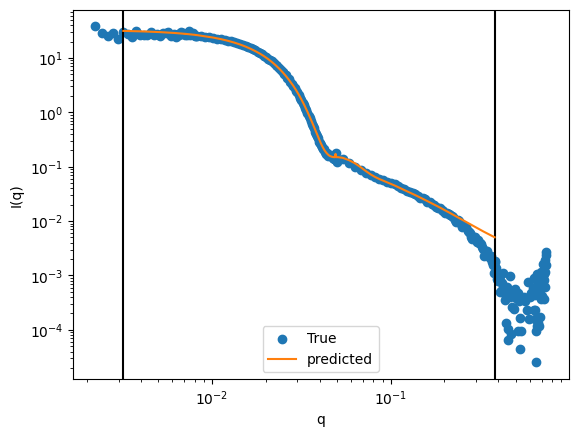

In [6]:
fig, ax = plt.subplots()
ax.scatter(data.x, data.y, label='True')
min_max_mask = (data.x >= data.qmin) & (data.x <= data.qmax)
q_mask = data.x[min_max_mask]
ax.axvline(x=data.qmin, color='k')
ax.axvline(x=data.qmax, color='k')   
ax.plot(q_mask, Iq_fitted, label='predicted', color='tab:orange')
ax.set_xlabel('q')
ax.set_ylabel('I(q)')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

### Debugging

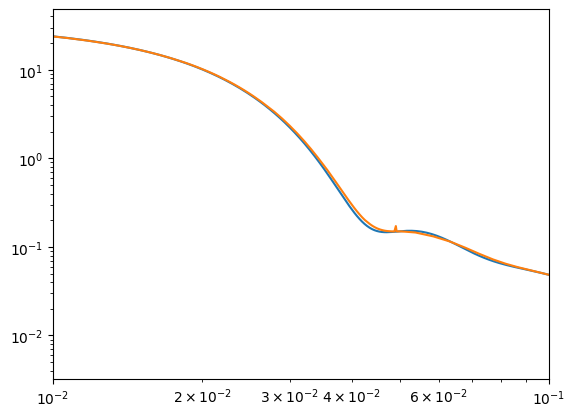

In [13]:
# debug fitted model 
q = np.logspace(-2, -1, 200)
model = kernel.make_kernel([q])
Iq_test = call_kernel(model, sphere_params)
fig, ax = plt.subplots()
ax.loglog(q, Iq_test)
ax.loglog(q_mask, Iq_fitted)
ax.set_xlim([1e-2, 1e-1])
plt.show()

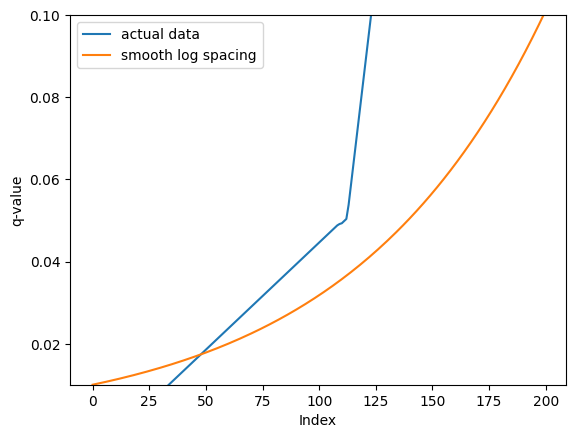

In [20]:
fig, ax = plt.subplots()
ax.plot(q_mask, label='actual data')
ax.plot(q, label='smooth log spacing')
ax.set_ylim([1e-2, 1e-1])
ax.set_xlabel('Index')
ax.set_ylabel('q-value')
ax.legend()
plt.show()

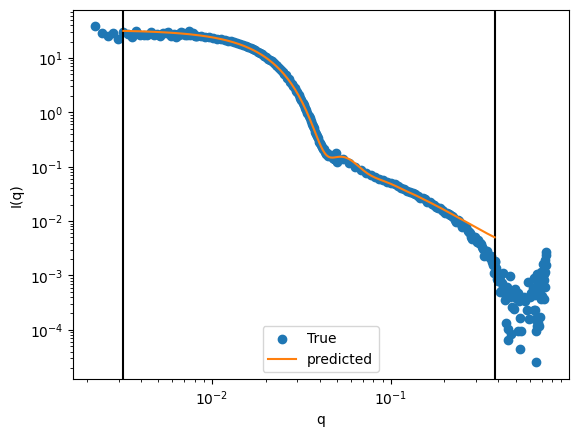

In [27]:
# debug fitted model 
q = np.logspace(np.log10(data.qmin), np.log10(data.qmax), 200).flatten()
model = kernel.make_kernel([q])
Iq_smooth_fitted = call_kernel(model, sphere_params)
fig, ax = plt.subplots()
ax.scatter(data.x, data.y, label='True')
ax.axvline(x=data.qmin, color='k')
ax.axvline(x=data.qmax, color='k')   
ax.plot(q, Iq_smooth_fitted, label='predicted', color='tab:orange')
ax.set_xlabel('q')
ax.set_ylabel('I(q)')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()